# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=45,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_14-39-31/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4814 | MulticlassF1Score=0.0971
Batch-30 : CrossEntropyLoss=2.4727 | MulticlassF1Score=0.1754
Batch-45 : CrossEntropyLoss=2.4628 | MulticlassF1Score=0.2201
Batch-60 : CrossEntropyLoss=2.4740 | MulticlassF1Score=0.2488
Batch-75 : CrossEntropyLoss=2.4457 | MulticlassF1Score=0.2725
Batch-90 : CrossEntropyLoss=2.4007 | MulticlassF1Score=0.3031
Batch-105: CrossEntropyLoss=2.3861 | MulticlassF1Score=0.3473
Batch-120: CrossEntropyLoss=2.3682 | MulticlassF1Score=0.3855
Batch-135: CrossEntropyLoss=2.3429 | MulticlassF1Score=0.4162
Batch-150: CrossEntropyLoss=2.3449 | MulticlassF1Score=0.4394
Batch-165: CrossEntropyLoss=2.3558 | MulticlassF1Score=0.4606
Batch-180: CrossEntropyLoss=2.3482 | MulticlassF1Score=0.4778
Batch-195: CrossEntropyLoss=2.3615 | MulticlassF1Score=0.4926
Batch-210: CrossEntropyLoss=2.3667 | MulticlassF1Score=0.5059
Batch-225: CrossEntropyLoss=2.3190 | MulticlassF1Score=0.5183
Batch-226: CrossEntropyLoss=2.3441 | MulticlassF1Score=0.5188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3205 | MulticlassF1Score=0.7119
Batch-30 : CrossEntropyLoss=2.3283 | MulticlassF1Score=0.7214
Batch-45 : CrossEntropyLoss=2.3406 | MulticlassF1Score=0.7182
Batch-60 : CrossEntropyLoss=2.3358 | MulticlassF1Score=0.7194
Batch-63 : CrossEntropyLoss=2.3429 | MulticlassF1Score=0.7185

Training   : Mean CrossEntropyLoss = 2.4074 | Mean MulticlassF1Score = 0.3435
Validation : Mean CrossEntropyLoss = 2.3373 | Mean MulticlassF1Score = 0.7161

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3309 | MulticlassF1Score=0.7379
Batch-30 : CrossEntropyLoss=2.3190 | MulticlassF1Score=0.7526
Batch-45 : CrossEntropyLoss=2.3152 | MulticlassF1Score=0.7610
Batch-60 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7678
Batch-75 : CrossEntropyLoss=2.3230 | MulticlassF1Score=0.7715
Batch-90 : CrossEntropyLoss=2.3102 | MulticlassF1Score=0.7740
Batch-105: CrossEntropyLoss=2.3103 | MulticlassF1Score=0.7760
Batch-120: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7778
Batch-135: CrossEntropyLoss=2.3128 | MulticlassF1Score=0.7790
Batch-150: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.7809
Batch-165: CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7808
Batch-180: CrossEntropyLoss=2.3220 | MulticlassF1Score=0.7815
Batch-195: CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7825
Batch-210: CrossEntropyLoss=2.3063 | MulticlassF1Score=0.7832
Batch-225: CrossEntropyLoss=2.3254 | MulticlassF1Score=0.7834
Batch-226: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.7835

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3179 | MulticlassF1Score=0.7897
Batch-30 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7929
Batch-45 : CrossEntropyLoss=2.3146 | MulticlassF1Score=0.7952
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.7928
Batch-63 : CrossEntropyLoss=2.3229 | MulticlassF1Score=0.7922

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3162 | Mean MulticlassF1Score = 0.7708
Validation : Mean CrossEntropyLoss = 2.3126 | Mean MulticlassF1Score = 0.7929

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3182 | MulticlassF1Score=0.7940
Batch-30 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.7972
Batch-45 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7966
Batch-60 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7971
Batch-75 : CrossEntropyLoss=2.3197 | MulticlassF1Score=0.7954
Batch-90 : CrossEntropyLoss=2.3086 | MulticlassF1Score=0.7960
Batch-105: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.7954
Batch-120: CrossEntropyLoss=2.3076 | MulticlassF1Score=0.7956
Batch-135: CrossEntropyLoss=2.3138 | MulticlassF1Score=0.7950
Batch-150: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7963
Batch-165: CrossEntropyLoss=2.3123 | MulticlassF1Score=0.7971
Batch-180: CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7978
Batch-195: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.7985
Batch-210: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7990
Batch-225: CrossEntropyLoss=2.3107 | MulticlassF1Score=0.7997
Batch-226: CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7997

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8042
Batch-30 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8066
Batch-45 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8065
Batch-60 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8065
Batch-63 : CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8060

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3103 | Mean MulticlassF1Score = 0.7965
Validation : Mean CrossEntropyLoss = 2.3080 | Mean MulticlassF1Score = 0.8050

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8078
Batch-30 : CrossEntropyLoss=2.3113 | MulticlassF1Score=0.8077
Batch-45 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8089
Batch-60 : CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8099
Batch-75 : CrossEntropyLoss=2.3131 | MulticlassF1Score=0.8113
Batch-90 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8111
Batch-105: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8105
Batch-120: CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8119
Batch-135: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8141
Batch-150: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8148
Batch-165: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8168
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8173
Batch-195: CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8182
Batch-210: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8188
Batch-225: CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8193
Batch-226: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8193

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3084 | MulticlassF1Score=0.8300
Batch-30 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8294
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8276
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8271
Batch-63 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.8270

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3039 | Mean MulticlassF1Score = 0.8127
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8300

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8292
Batch-30 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8316
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8338
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8334
Batch-75 : CrossEntropyLoss=2.3063 | MulticlassF1Score=0.8314
Batch-90 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8315
Batch-105: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.8309
Batch-120: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8310
Batch-135: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8308
Batch-150: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8307
Batch-165: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8304
Batch-180: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8300
Batch-195: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8302
Batch-210: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8307
Batch-225: CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8318
Batch-226: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8319

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8447
Batch-30 : CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8421
Batch-45 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8417
Batch-60 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8412
Batch-63 : CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8415

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2999 | Mean MulticlassF1Score = 0.8306
Validation : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8420

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8478
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8453
Batch-45 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8446
Batch-60 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8460
Batch-75 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8471
Batch-90 : CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8466
Batch-105: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8472
Batch-120: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8478
Batch-135: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8481
Batch-150: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8483
Batch-165: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8478
Batch-180: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8479
Batch-195: CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8481
Batch-210: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8482
Batch-225: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8482
Batch-226: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8442
Batch-30 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8448
Batch-45 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8442
Batch-60 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8458
Batch-63 : CrossEntropyLoss=2.3080 | MulticlassF1Score=0.8456

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2951 | Mean MulticlassF1Score = 0.8471
Validation : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8454

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8472
Batch-30 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8469
Batch-45 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8488
Batch-60 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8485
Batch-75 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8491
Batch-90 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8492
Batch-105: CrossEntropyLoss=2.2831 | MulticlassF1Score=0.8497
Batch-120: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8499
Batch-135: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8502
Batch-150: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8504
Batch-165: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8506
Batch-180: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8505
Batch-195: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8502
Batch-210: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8501
Batch-225: CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8506
Batch-226: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8507

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8485
Batch-30 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8469
Batch-45 : CrossEntropyLoss=2.3061 | MulticlassF1Score=0.8476
Batch-60 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8468
Batch-63 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2941 | Mean MulticlassF1Score = 0.8497
Validation : Mean CrossEntropyLoss = 2.2952 | Mean MulticlassF1Score = 0.8483

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8527
Batch-30 : CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8566
Batch-45 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8521
Batch-60 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8541
Batch-75 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8534
Batch-90 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8540
Batch-105: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8538
Batch-120: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8533
Batch-135: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8536
Batch-150: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8533
Batch-165: CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8532
Batch-180: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8534
Batch-195: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8533
Batch-210: CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8530
Batch-225: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8525
Batch-226: CrossEntropyLoss=2.2879 | MulticlassF1Score=0.8525

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8444
Batch-30 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8457
Batch-45 : CrossEntropyLoss=2.2933 | MulticlassF1Score=0.8480
Batch-60 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8475
Batch-63 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8533
Validation : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8457

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8497
Batch-30 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8519
Batch-45 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8515
Batch-60 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8538
Batch-75 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8537
Batch-90 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8535
Batch-105: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8533
Batch-120: CrossEntropyLoss=2.2996 | MulticlassF1Score=0.8530
Batch-135: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8533
Batch-150: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8531
Batch-165: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8534
Batch-180: CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8536
Batch-195: CrossEntropyLoss=2.2893 | MulticlassF1Score=0.8539
Batch-210: CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8537
Batch-225: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8537
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8537

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8464
Batch-30 : CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8461
Batch-45 : CrossEntropyLoss=2.2955 | MulticlassF1Score=0.8463
Batch-60 : CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8467
Batch-63 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2930 | Mean MulticlassF1Score = 0.8528
Validation : Mean CrossEntropyLoss = 2.2948 | Mean MulticlassF1Score = 0.8480

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8510
Batch-30 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8538
Batch-45 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8561
Batch-60 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8550
Batch-75 : CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8551
Batch-90 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8549
Batch-105: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8555
Batch-120: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8549
Batch-135: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8552
Batch-150: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8548
Batch-165: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8555
Batch-180: CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8552
Batch-195: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8553
Batch-210: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8555
Batch-225: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8552
Batch-226: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8551

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8440
Batch-30 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8491
Batch-45 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8490
Batch-60 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8491
Batch-63 : CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8547
Validation : Mean CrossEntropyLoss = 2.2945 | Mean MulticlassF1Score = 0.8479

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8552
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8560
Batch-45 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8553
Batch-60 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8569
Batch-75 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8556
Batch-90 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8555
Batch-105: CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8557
Batch-120: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8559
Batch-135: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8554
Batch-150: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8557
Batch-165: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8557
Batch-180: CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8558
Batch-195: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8559
Batch-210: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8563
Batch-225: CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8576
Batch-226: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8577

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8771
Batch-30 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8752
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8754
Batch-60 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8749
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8747

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2917 | Mean MulticlassF1Score = 0.8562
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8756

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8820
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8848
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8854
Batch-60 : CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8847
Batch-75 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8851
Batch-90 : CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8861
Batch-105: CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8862
Batch-120: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8861
Batch-135: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8867
Batch-150: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8867
Batch-165: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8865
Batch-180: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8868
Batch-195: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8871
Batch-210: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8874
Batch-225: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8872
Batch-226: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8872

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8849
Batch-30 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8849
Batch-45 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8846
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8827
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8828

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2829 | Mean MulticlassF1Score = 0.8856
Validation : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8838

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8934
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.8941
Batch-45 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8942
Batch-60 : CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8934
Batch-75 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8913
Batch-90 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8909
Batch-105: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8910
Batch-120: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8905
Batch-135: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8907
Batch-150: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8911
Batch-165: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8915
Batch-180: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8916
Batch-195: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8916
Batch-210: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8922
Batch-225: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8938
Batch-226: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8938

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9097
Batch-30 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9113
Batch-45 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9107
Batch-60 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.9108
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9104

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8918
Validation : Mean CrossEntropyLoss = 2.2759 | Mean MulticlassF1Score = 0.9107

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9156
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9201
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9218
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9212
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9219
Batch-90 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9213
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9214
Batch-120: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9207
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9208
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9210
Batch-165: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9209
Batch-180: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9216
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9213
Batch-225: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9212
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9212

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9193
Batch-30 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9140
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9139

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9206
Validation : Mean CrossEntropyLoss = 2.2745 | Mean MulticlassF1Score = 0.9158

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9250
Batch-75 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9252
Batch-90 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9246
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9242
Batch-120: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9246
Batch-135: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9243
Batch-150: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9241
Batch-165: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9242
Batch-180: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9242
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9242
Batch-210: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9244
Batch-225: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9242
Batch-226: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9242

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9115
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9151
Batch-45 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9157
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9147
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9143

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9242
Validation : Mean CrossEntropyLoss = 2.2743 | Mean MulticlassF1Score = 0.9136

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9233
Batch-30 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9253
Batch-60 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9251
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9249
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9246
Batch-120: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9249
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9252
Batch-150: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9254
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9255
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9256
Batch-195: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9256
Batch-210: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9255
Batch-225: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9257
Batch-226: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9257

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9145
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9140
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9146
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9149

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9250
Validation : Mean CrossEntropyLoss = 2.2739 | Mean MulticlassF1Score = 0.9153

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9339
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9337
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9348
Batch-75 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9344
Batch-90 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9341
Batch-105: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9339
Batch-120: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9334
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9334
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9338
Batch-165: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9341
Batch-180: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9341
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9343
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9341
Batch-225: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9343
Batch-226: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9343

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9240
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9251
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9229
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9232

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9336
Validation : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9242

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9336
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9358
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9372
Batch-75 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9367
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9364
Batch-105: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9370
Batch-150: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9366
Batch-195: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9365
Batch-210: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9360
Batch-225: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9356

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9225
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9226
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9225
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9228
Batch-63 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9225

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9362
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9230

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9385
Batch-30 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9367
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9375
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9368
Batch-75 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9369
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9397
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9413
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9452
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9465
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9471
Batch-210: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9477
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9482
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9482

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9425
Batch-60 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9419
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9437

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9550
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9546
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9551
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9558
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9561
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9566
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9561
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9556
Batch-135: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9553
Batch-150: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9553
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9554
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9555
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9555
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9553
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9555
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9555

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9413
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9410
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9425
Batch-63 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9425

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2614 | Mean MulticlassF1Score = 0.9555
Validation : Mean CrossEntropyLoss = 2.2656 | Mean MulticlassF1Score = 0.9417

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9581
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9563
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9569
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9567
Batch-75 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9571
Batch-90 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9575
Batch-105: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9579
Batch-120: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9576
Batch-135: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9570
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9569
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9569
Batch-180: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9569
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9568
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9566
Batch-225: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9566
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9566

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9430
Batch-45 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9422
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9429

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2610 | Mean MulticlassF1Score = 0.9571
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9451

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9602
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9592
Batch-45 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9588
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9576
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9572
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9570
Batch-105: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9570
Batch-120: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9571
Batch-135: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9571
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9575
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9574
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9572
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9572
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9573
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9575
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9575

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9428
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9424

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2607 | Mean MulticlassF1Score = 0.9580
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9432

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9611
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9604
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9594
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9590
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9592
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9588
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9589
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9590
Batch-135: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9590
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9588
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9590
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9586
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9584
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9583
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9417
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9432
Batch-60 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9429
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9426

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9592
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9427

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9557
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9582
Batch-45 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9588
Batch-60 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9597
Batch-75 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9597
Batch-90 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9595
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9592
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9593
Batch-150: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9590
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9587
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9588
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9588
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9587
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9587
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9587

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9434
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9429
Batch-45 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9440
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9432
Batch-63 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9430

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9585
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9434

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9599
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9603
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9599
Batch-75 : CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9599
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9588
Batch-105: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9589
Batch-120: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9587
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9586
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9589
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9587
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9587
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9587
Batch-210: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9587
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9587

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9457
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9441
Batch-63 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9440

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9591
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9470
Patience = 1/50❗

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9569
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9577
Batch-45 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9590
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9595
Batch-75 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9580
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9583
Batch-105: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9587
Batch-120: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9587
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9583
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9584
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9587
Batch-210: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9591
Batch-226: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9590

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9445
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9444

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9585
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9473

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9594
Batch-30 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9589
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9592
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9592
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9588
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9598
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9596
Batch-120: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9589
Batch-135: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9588
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9591
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9591
Batch-180: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9591
Batch-195: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9589
Batch-210: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9591
Batch-226: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9591

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9444
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9427
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9431
Batch-63 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9432

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2602 | Mean MulticlassF1Score = 0.9593
Validation : Mean CrossEntropyLoss = 2.2652 | Mean MulticlassF1Score = 0.9436

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9613
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9625
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9620
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9610
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9597
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9594
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9593
Batch-120: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9596
Batch-135: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9598
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9602
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9605
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9606
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9611
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9610
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9611

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9466

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9606
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9465

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9663
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9639
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9640
Batch-60 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9646
Batch-90 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9642
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9639
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9641
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9638
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9637
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9638
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9637
Batch-210: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9470
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2587 | Mean MulticlassF1Score = 0.9639
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9465

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9657
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9655
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9654
Batch-150: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9650
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9651
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9650
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9650
Batch-225: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9650

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9454
Batch-30 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9658
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9473

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9663
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9663
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9662
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9659
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9660
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9661
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9660
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9659
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9657
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9658

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9483

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9684
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9664
Batch-75 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9665
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9668
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9664
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9666
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9666
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9666
Batch-195: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9666
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9663
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9662
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9662

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2580 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9679
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9671
Batch-45 : CrossEntropyLoss=2.2531 | MulticlassF1Score=0.9676
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9672
Batch-150: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9674
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9673
Batch-180: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9671
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9668
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9667

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9500
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9485

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9671
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9501

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9673
Batch-30 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9660
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9666
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9671
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9668
Batch-150: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9668
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9668
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9672
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9672
Batch-225: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9671
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9671

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9465
Batch-45 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9477
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9666
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9478

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9681
Batch-60 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9683
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9679
Batch-135: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9676
Batch-165: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9674
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9674
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9673
Batch-210: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9674
Batch-225: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9675
Batch-226: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9675

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9514
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9500
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9682
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9507

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9694
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9677
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9491
Batch-45 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9485
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9486

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9496

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9703
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9688
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9682
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9680
Batch-226: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9680

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9502
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9503
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9493
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9494

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9502

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9700
Batch-75 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9689
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9688
Batch-135: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9681
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9509
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9490
Batch-63 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9504

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-45 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9682
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9681
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9481
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9490

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9680
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9480

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9650
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9683
Batch-150: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9686
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9485
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9681
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9480

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9675
Batch-30 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9702
Batch-60 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9700
Batch-105: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9703
Batch-135: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9696
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9457

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9669
Batch-30 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9668
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9684
Batch-150: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9682
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9685
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9685
Batch-226: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9685

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9503
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9684
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9497
Patience = 2/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-45 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9690
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9690
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9692
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9479

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9690
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9473

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9691
Batch-45 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9687
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9686
Batch-135: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9687
Batch-165: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9691
Batch-225: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9488
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9489

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9476

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9713
Batch-30 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9693
Batch-180: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9692
Batch-210: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9694
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9694

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9490
Batch-30 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9494
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9487

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9496

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9685
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9701
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9694
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9492
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9490
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9495

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2631 | Mean MulticlassF1Score = 0.9491

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-105: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9702

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9513
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9518
Batch-45 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9510
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9495
Batch-63 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9500

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2630 | Mean MulticlassF1Score = 0.9514

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9677
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9687
Batch-45 : CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9700
Batch-60 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9699
Batch-75 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9701
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9703
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9702
Batch-225: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9701
Batch-226: CrossEntropyLoss=2.2524 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9519
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9493
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9491
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9491

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9695
Validation : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9499
Patience = 3/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9710
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9705
Batch-75 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9704
Batch-90 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9706
Batch-120: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9704
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9702
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9704
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9699
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9701
Batch-225: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9699
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9699

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9507
Batch-30 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9504
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9501
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9491

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9499
Patience = 4/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9691
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-90 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9705
Batch-165: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9702
Batch-180: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9698
Batch-225: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9697
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9479
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483
Patience = 5/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2566
Best CrossEntropyLoss training    : 2.2630
Best MulticlassF1Score validation : 0.9689
Best MulticlassF1Score validation : 0.9514
Training duration                 : 2.3190 minutes.
Training date                     : 2022-10-19 10:29:49.397765+08:00


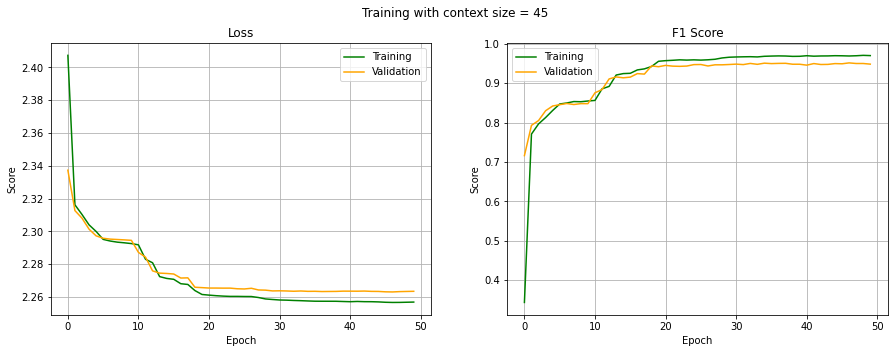

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9700, device='cuda:0'),
 tensor(0.9485, device='cuda:0'),
 tensor(0.9457, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9700, device='cuda:0'),
 tensor(0.9485, device='cuda:0'),
 tensor(0.9457, device='cuda:0'))

## Heatmap

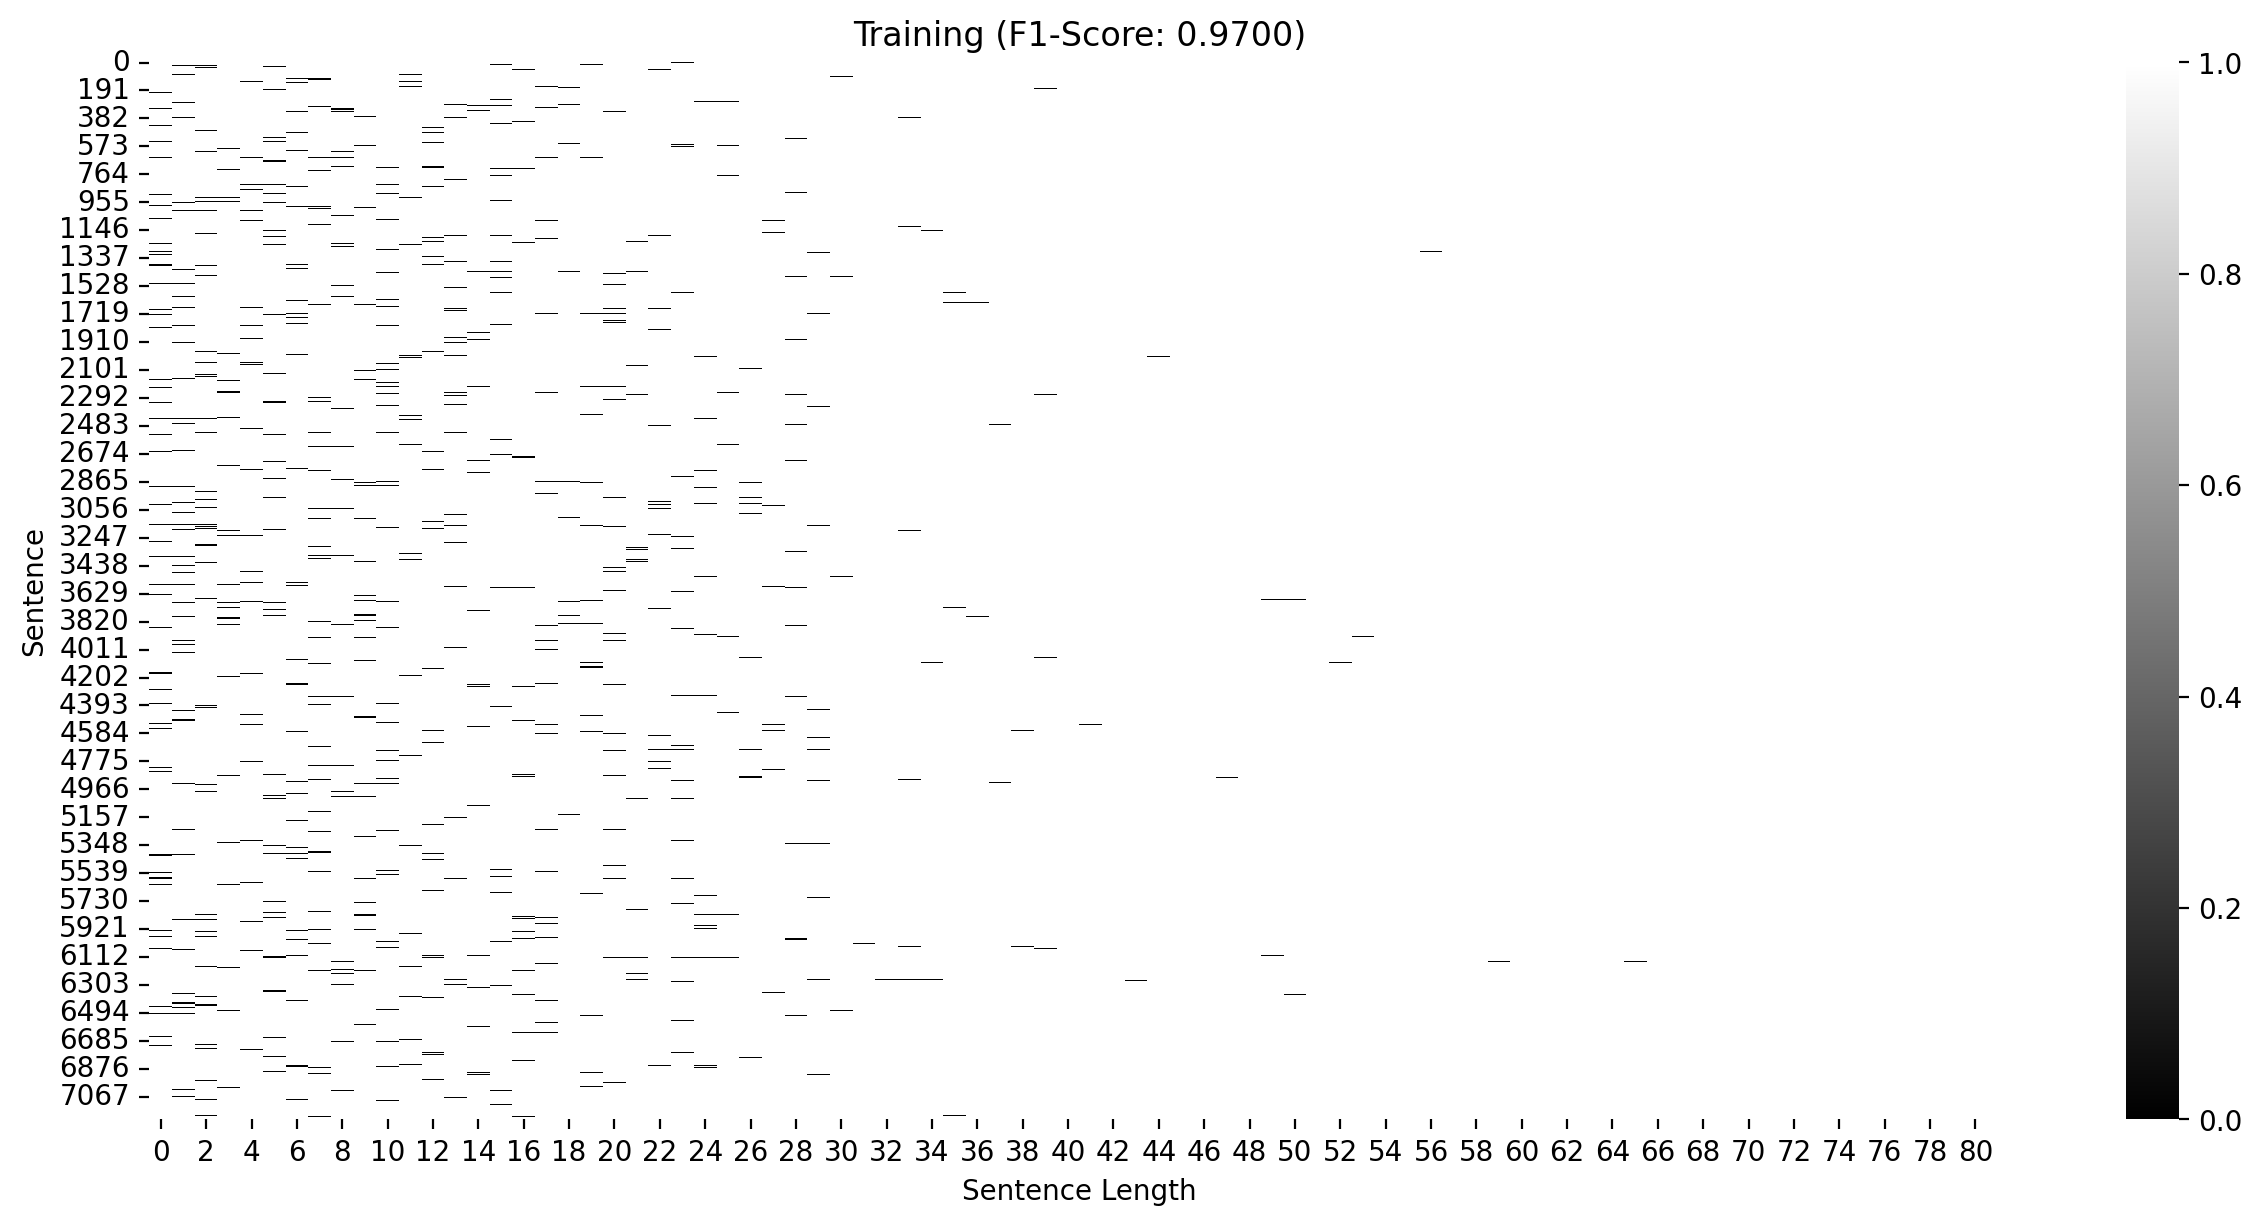

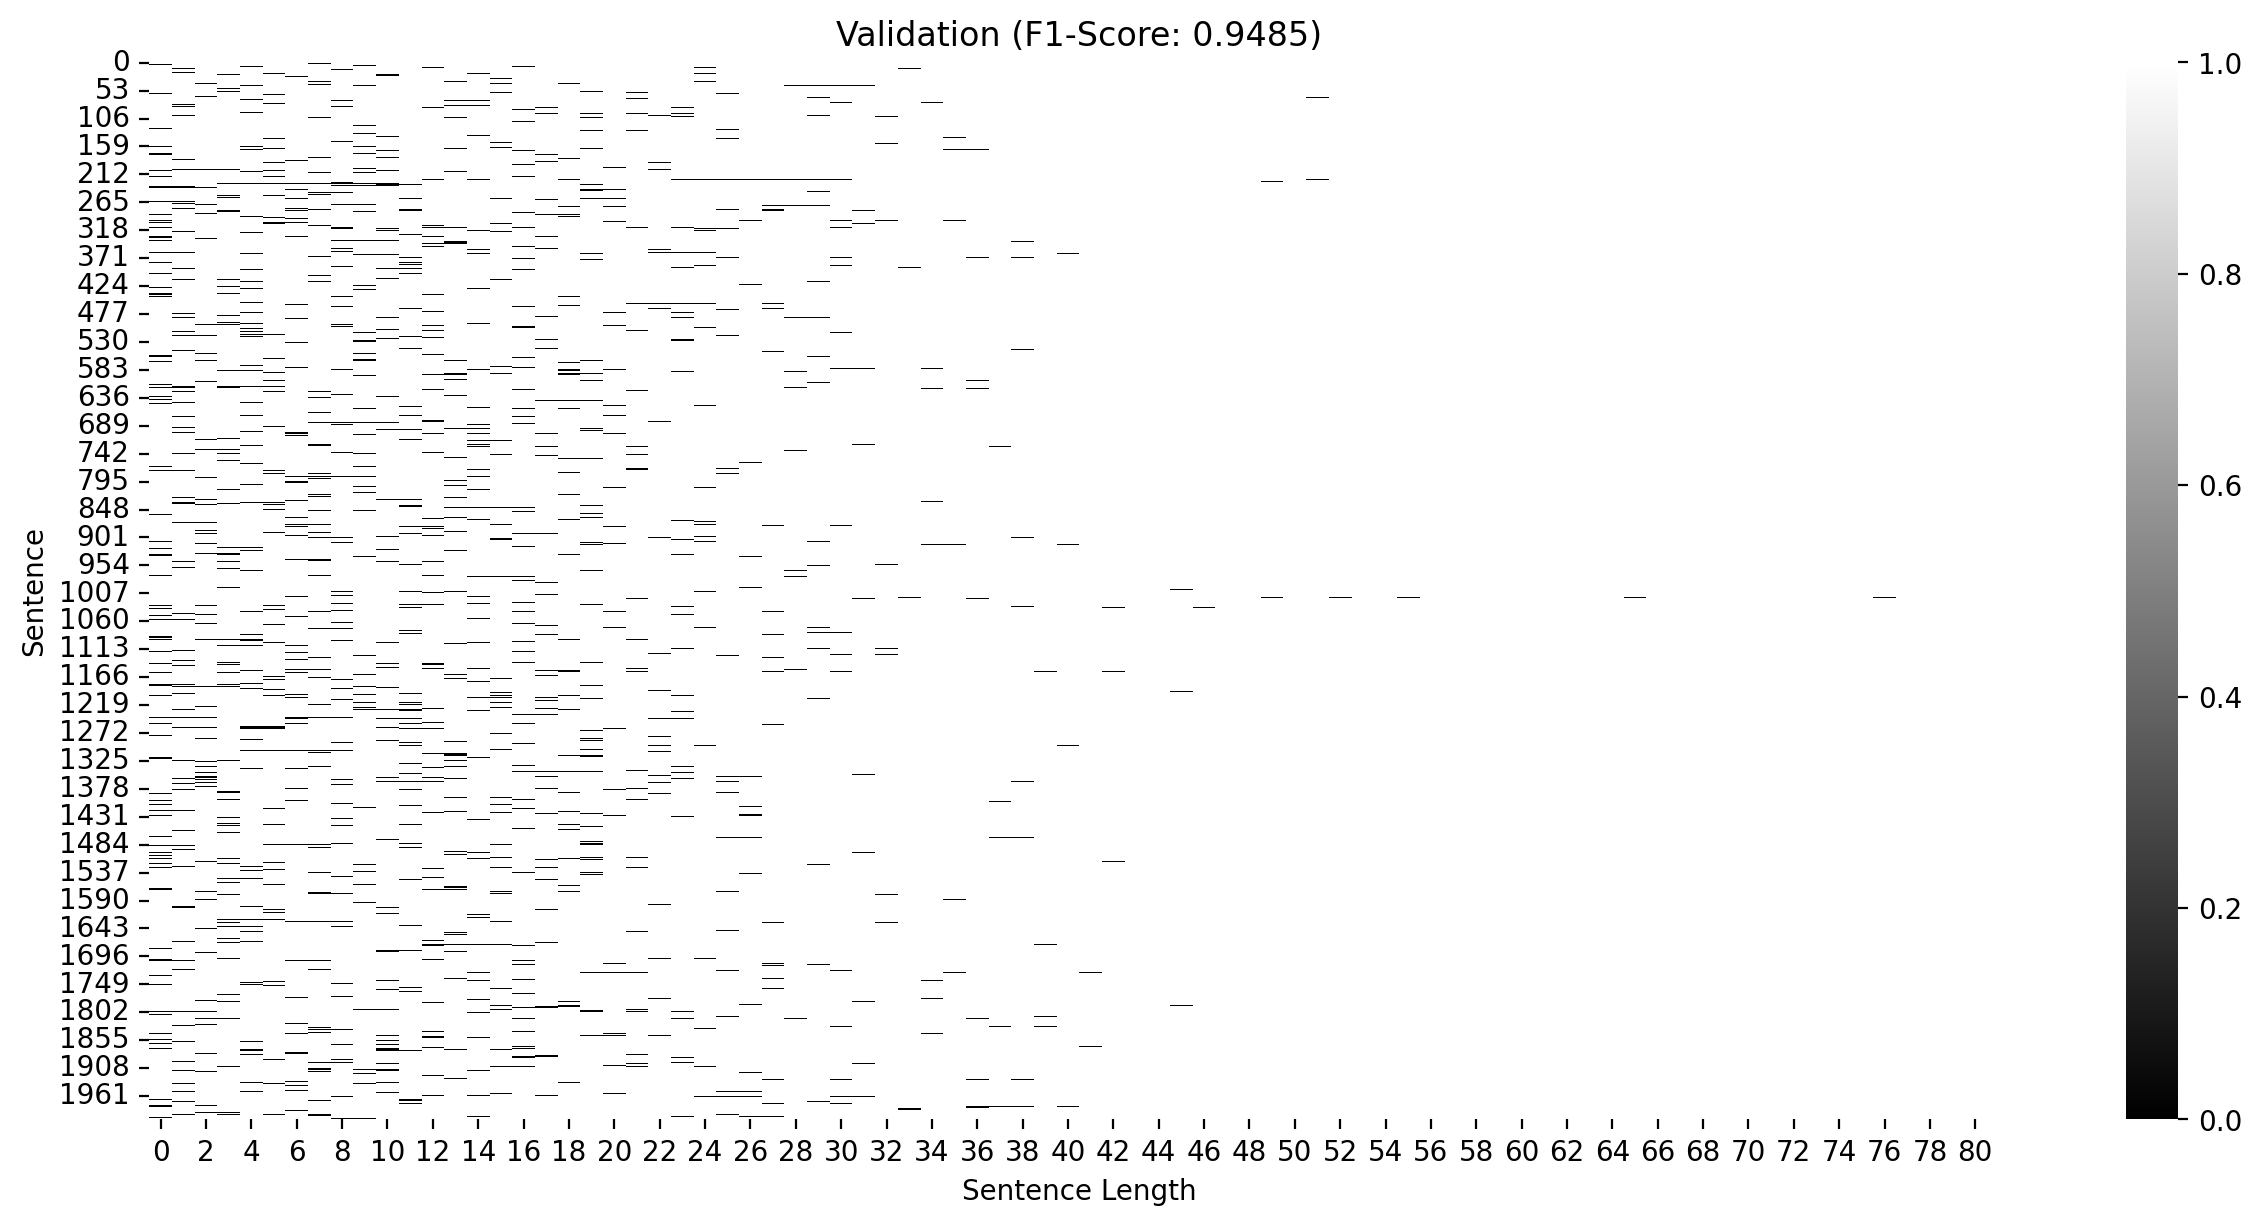

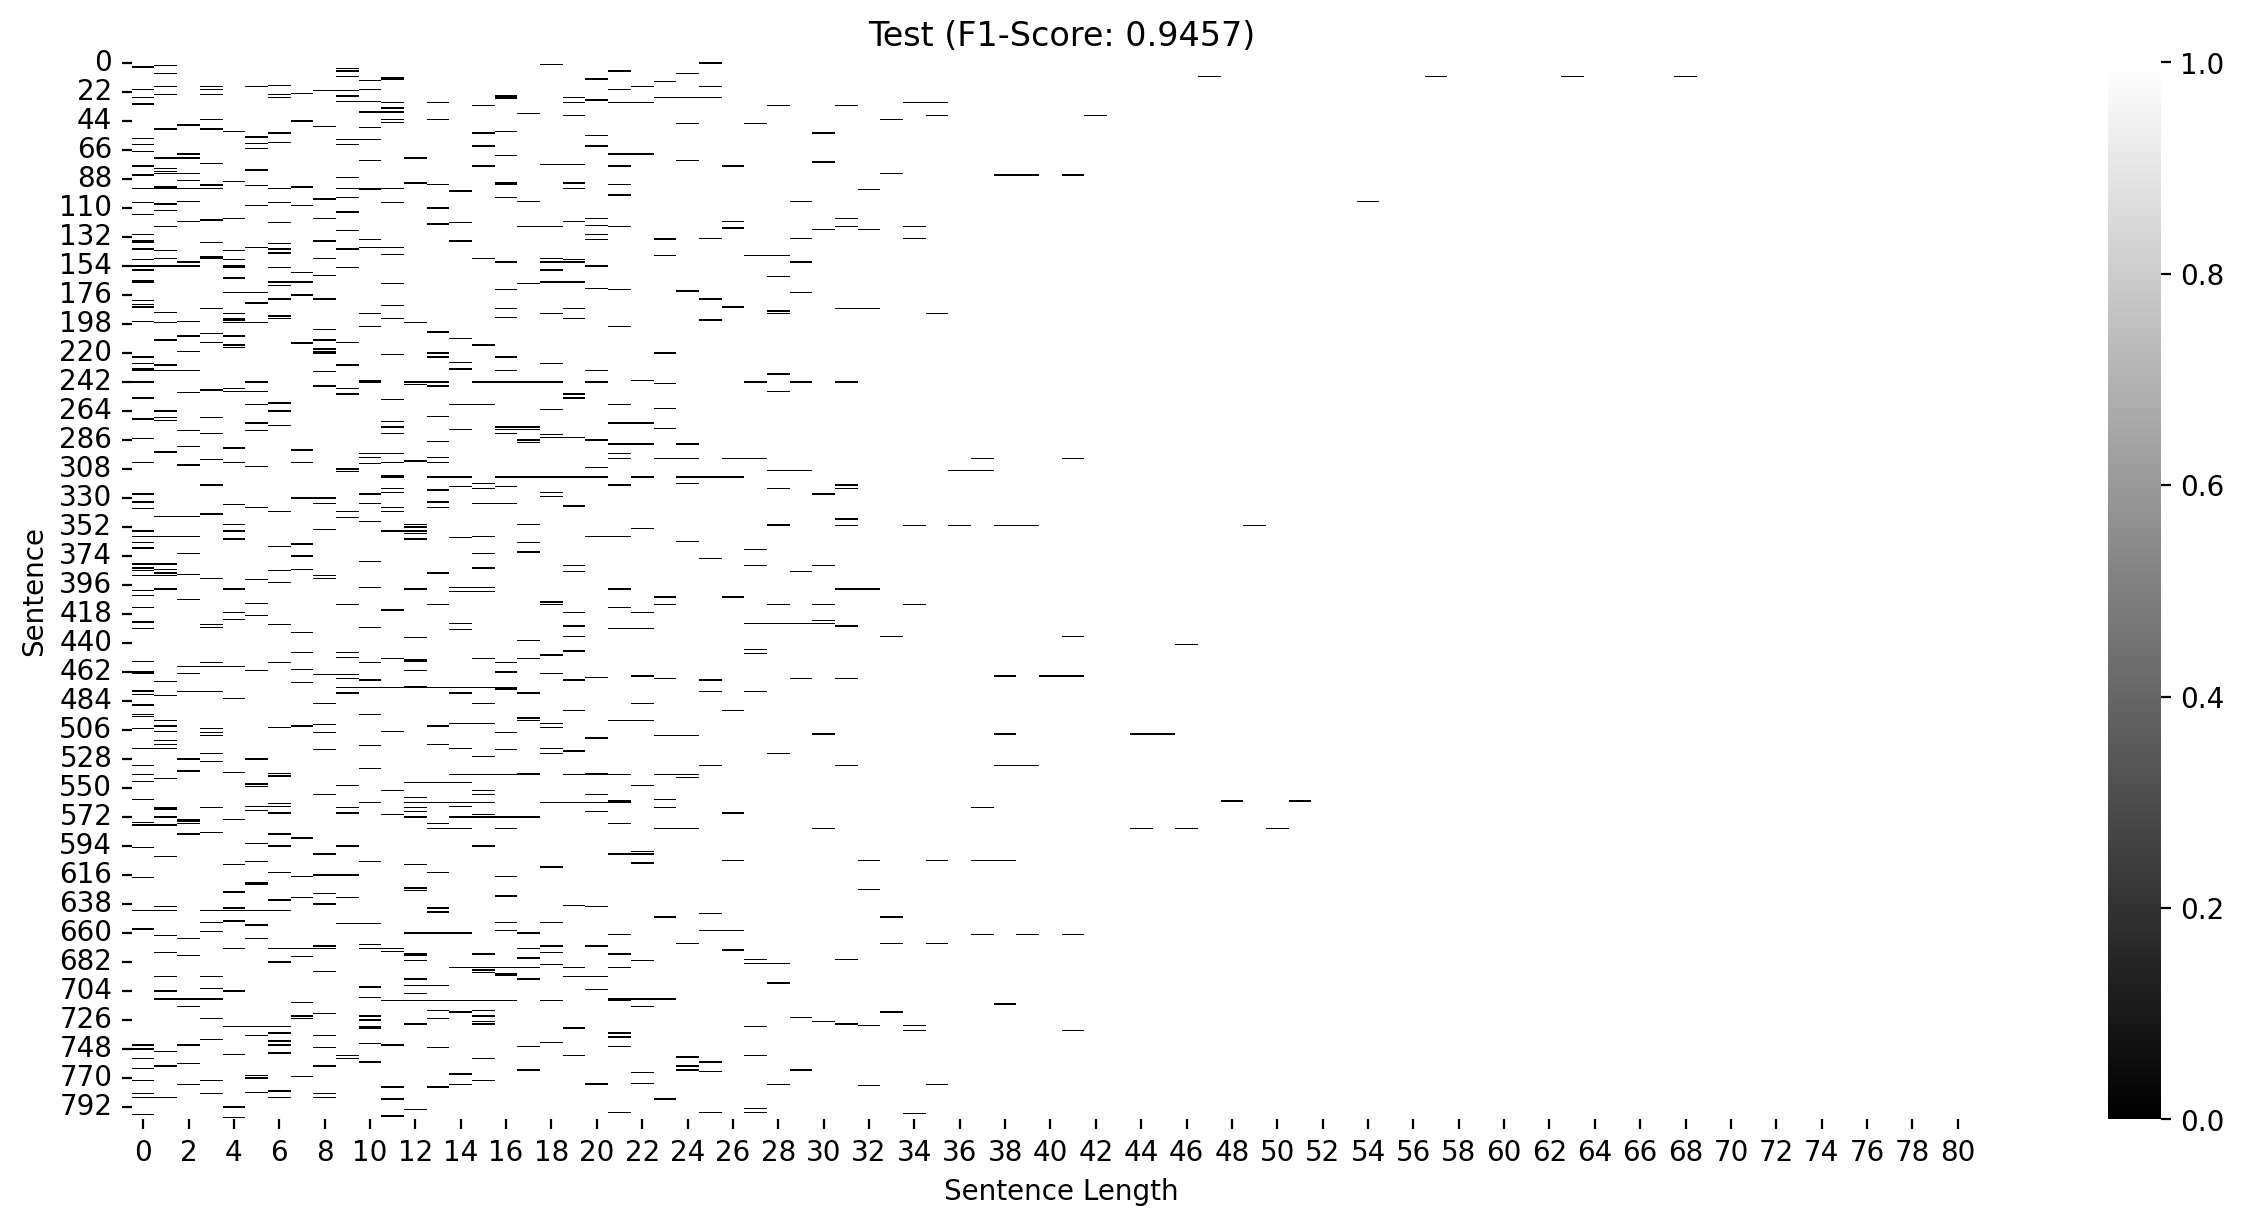

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


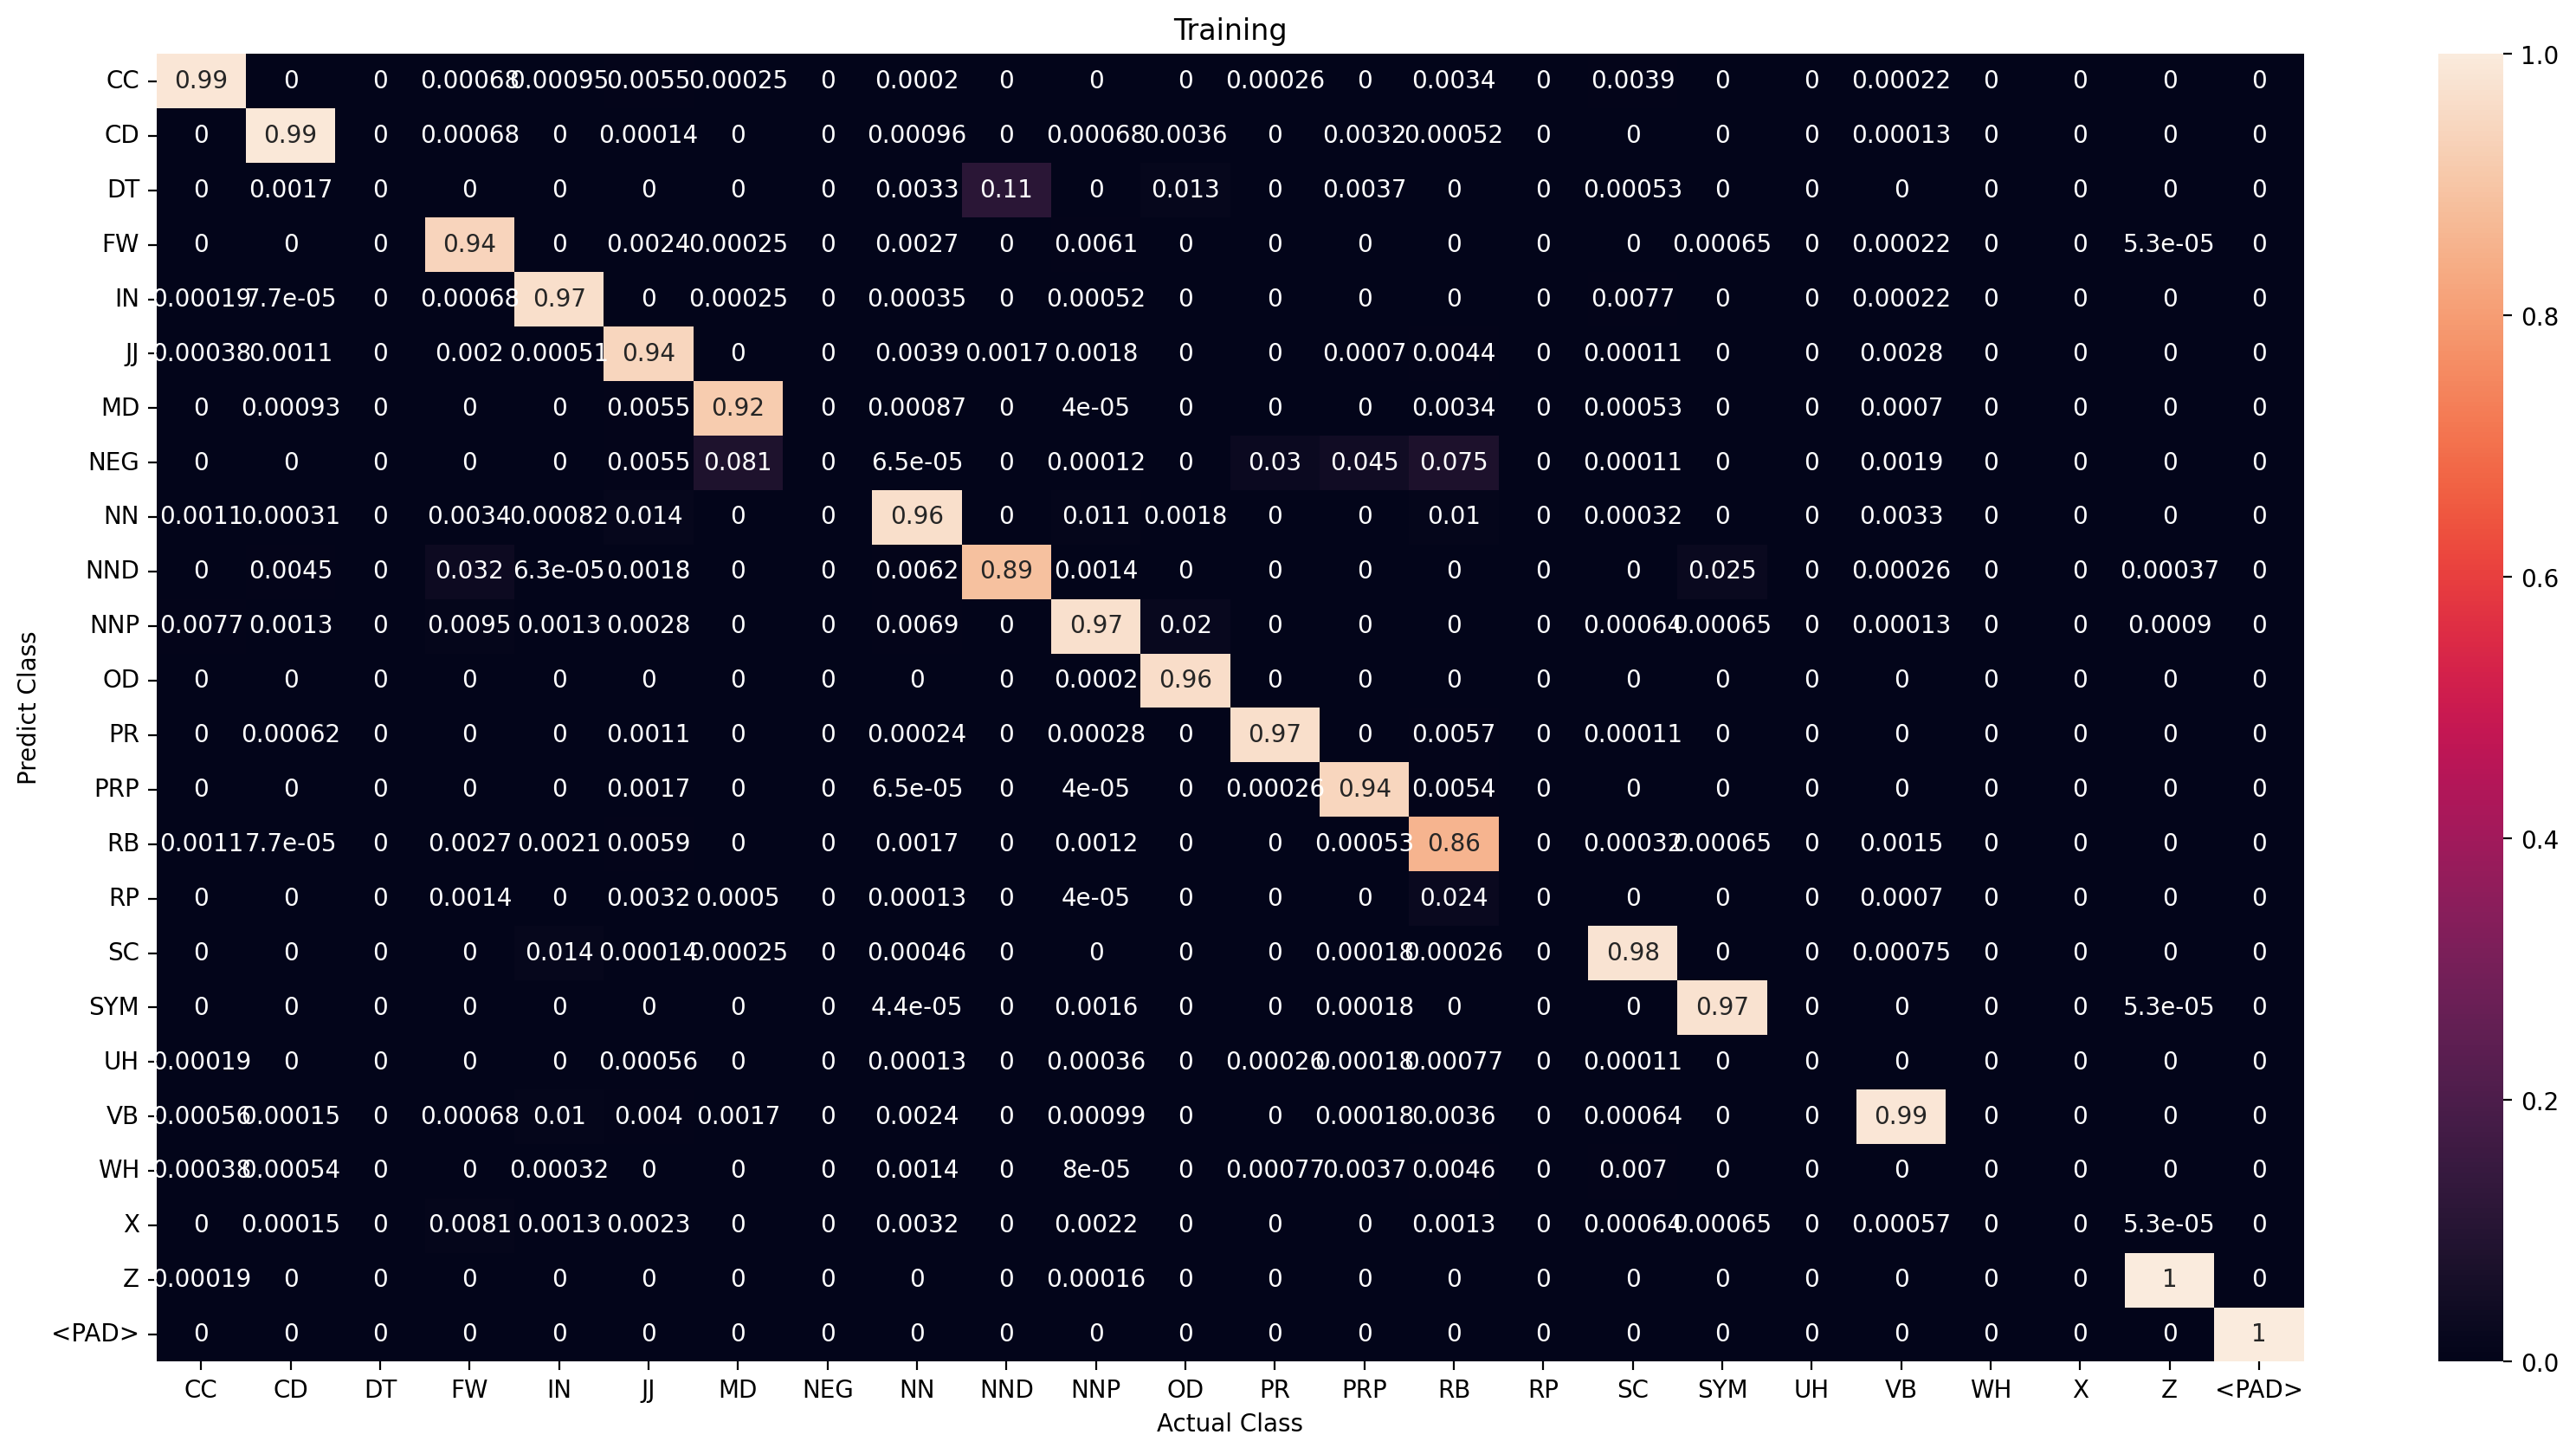

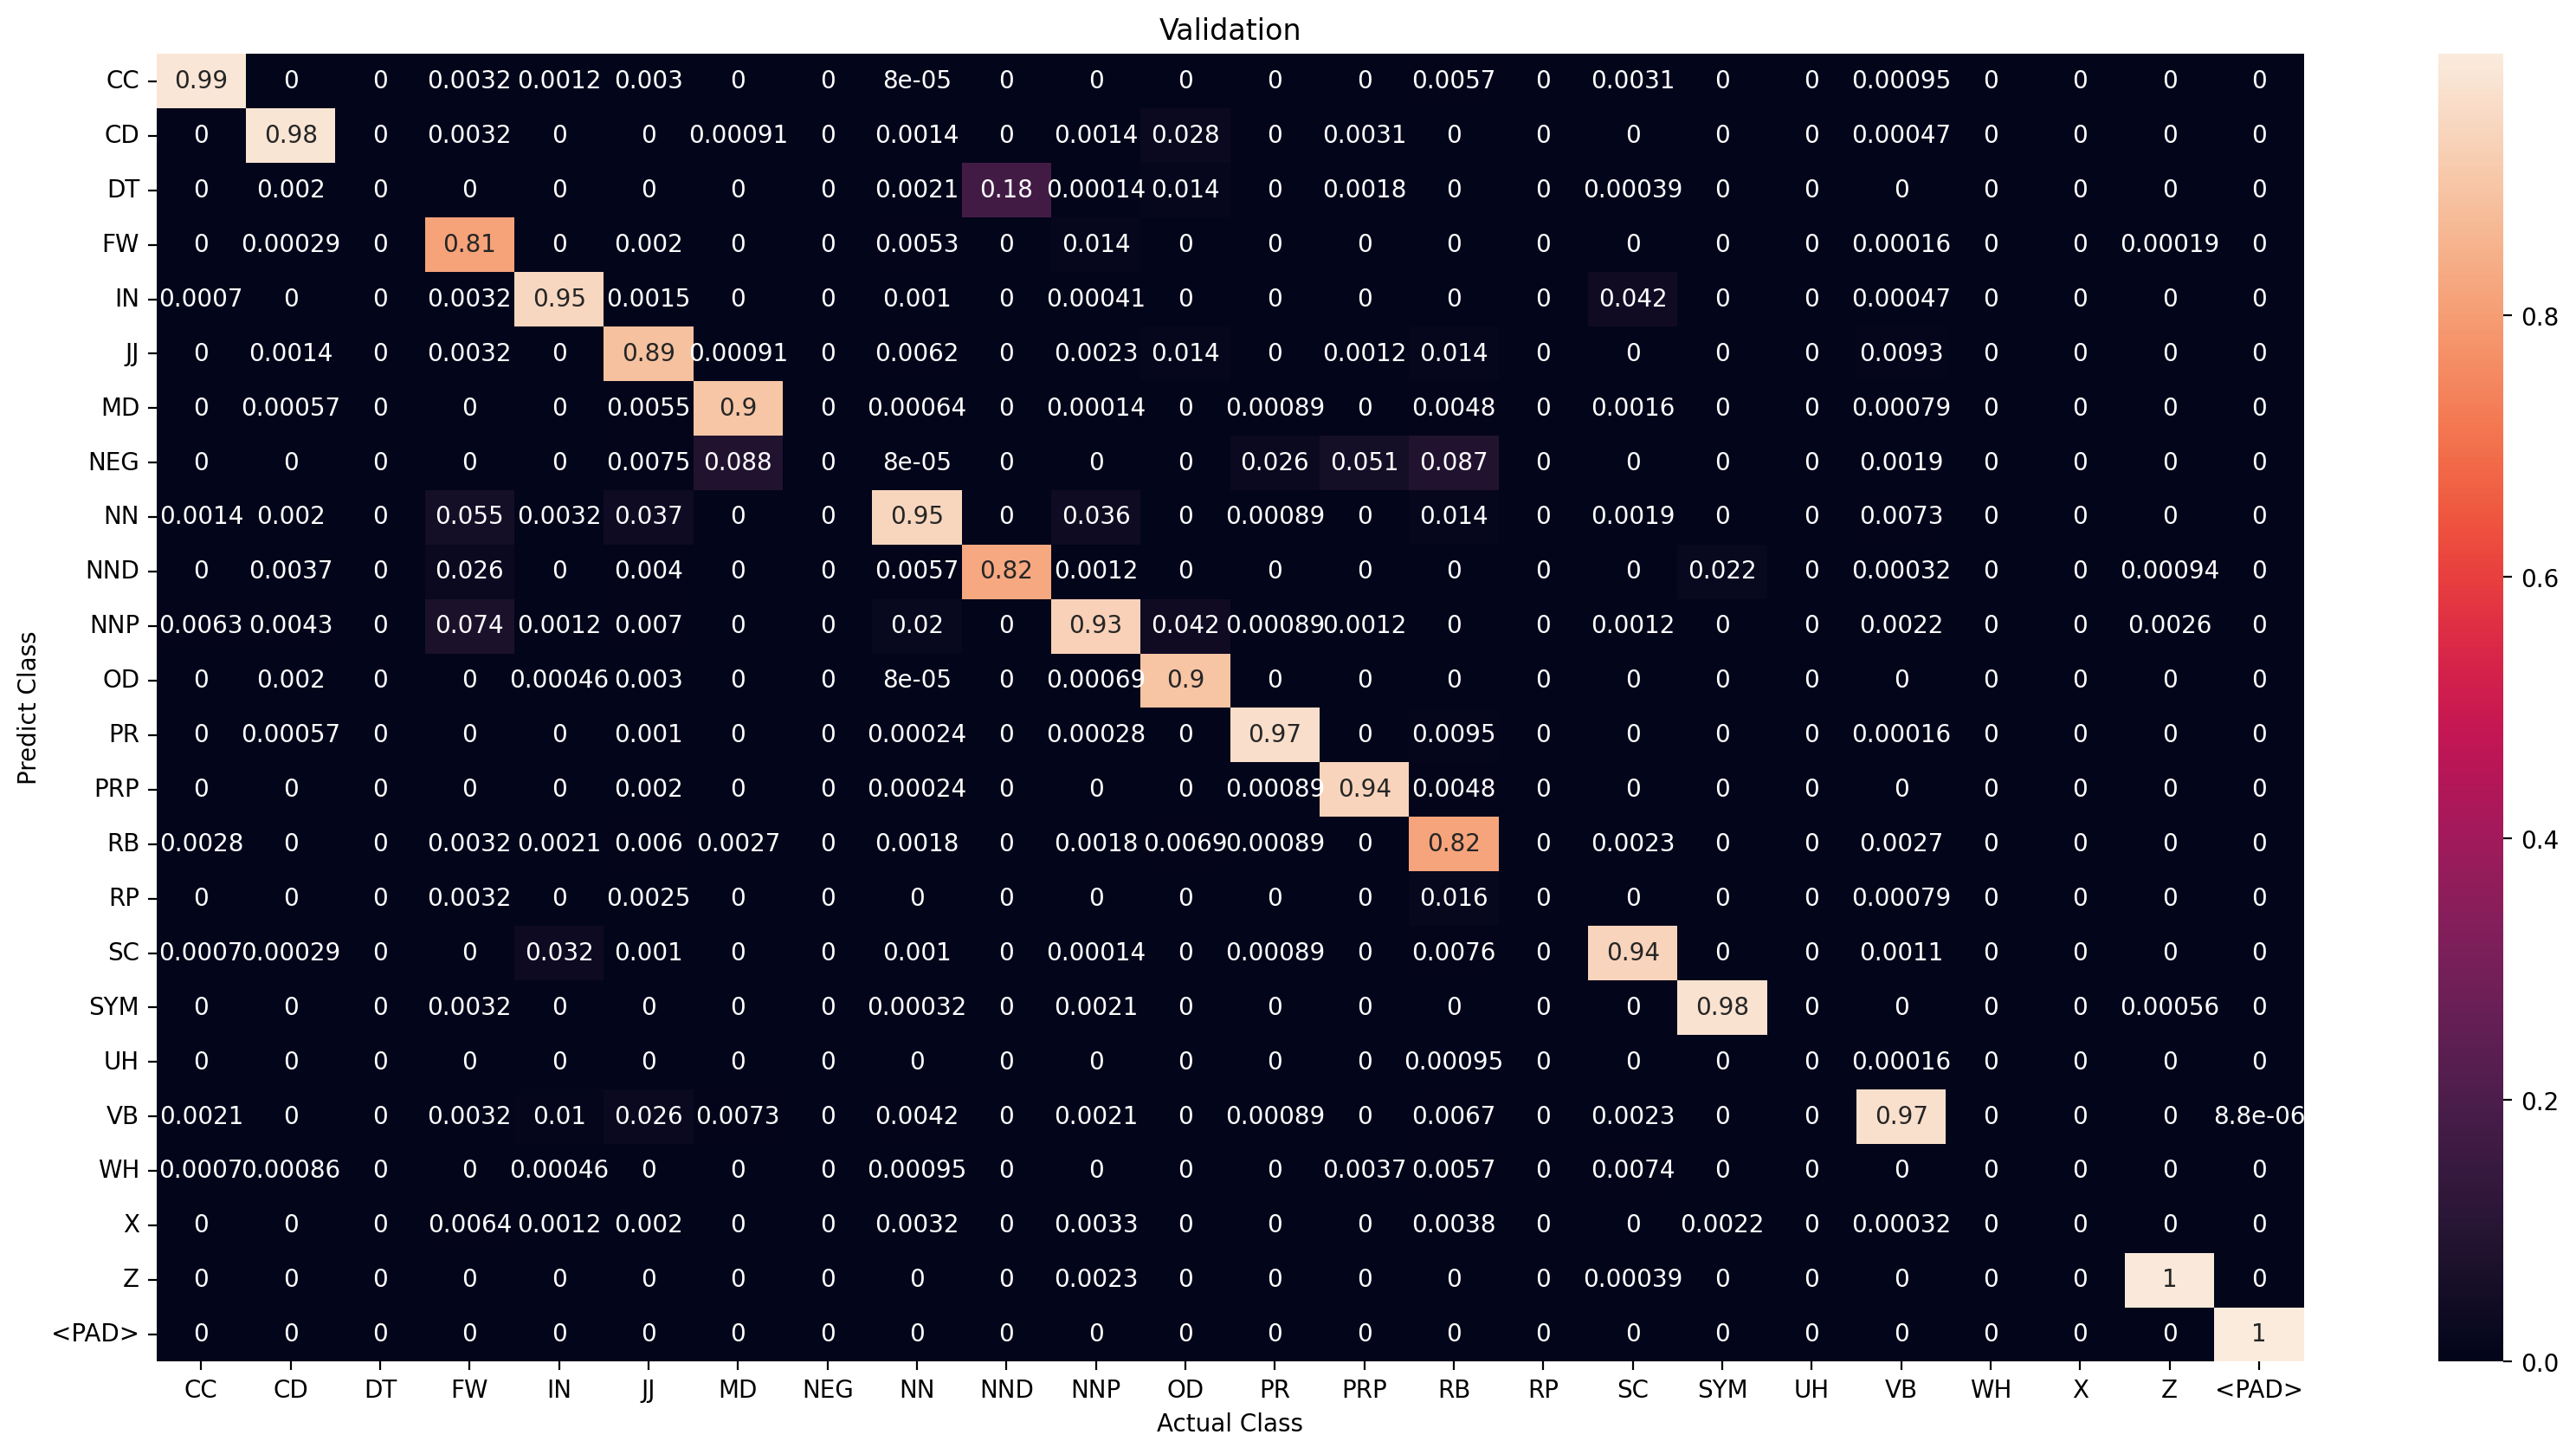

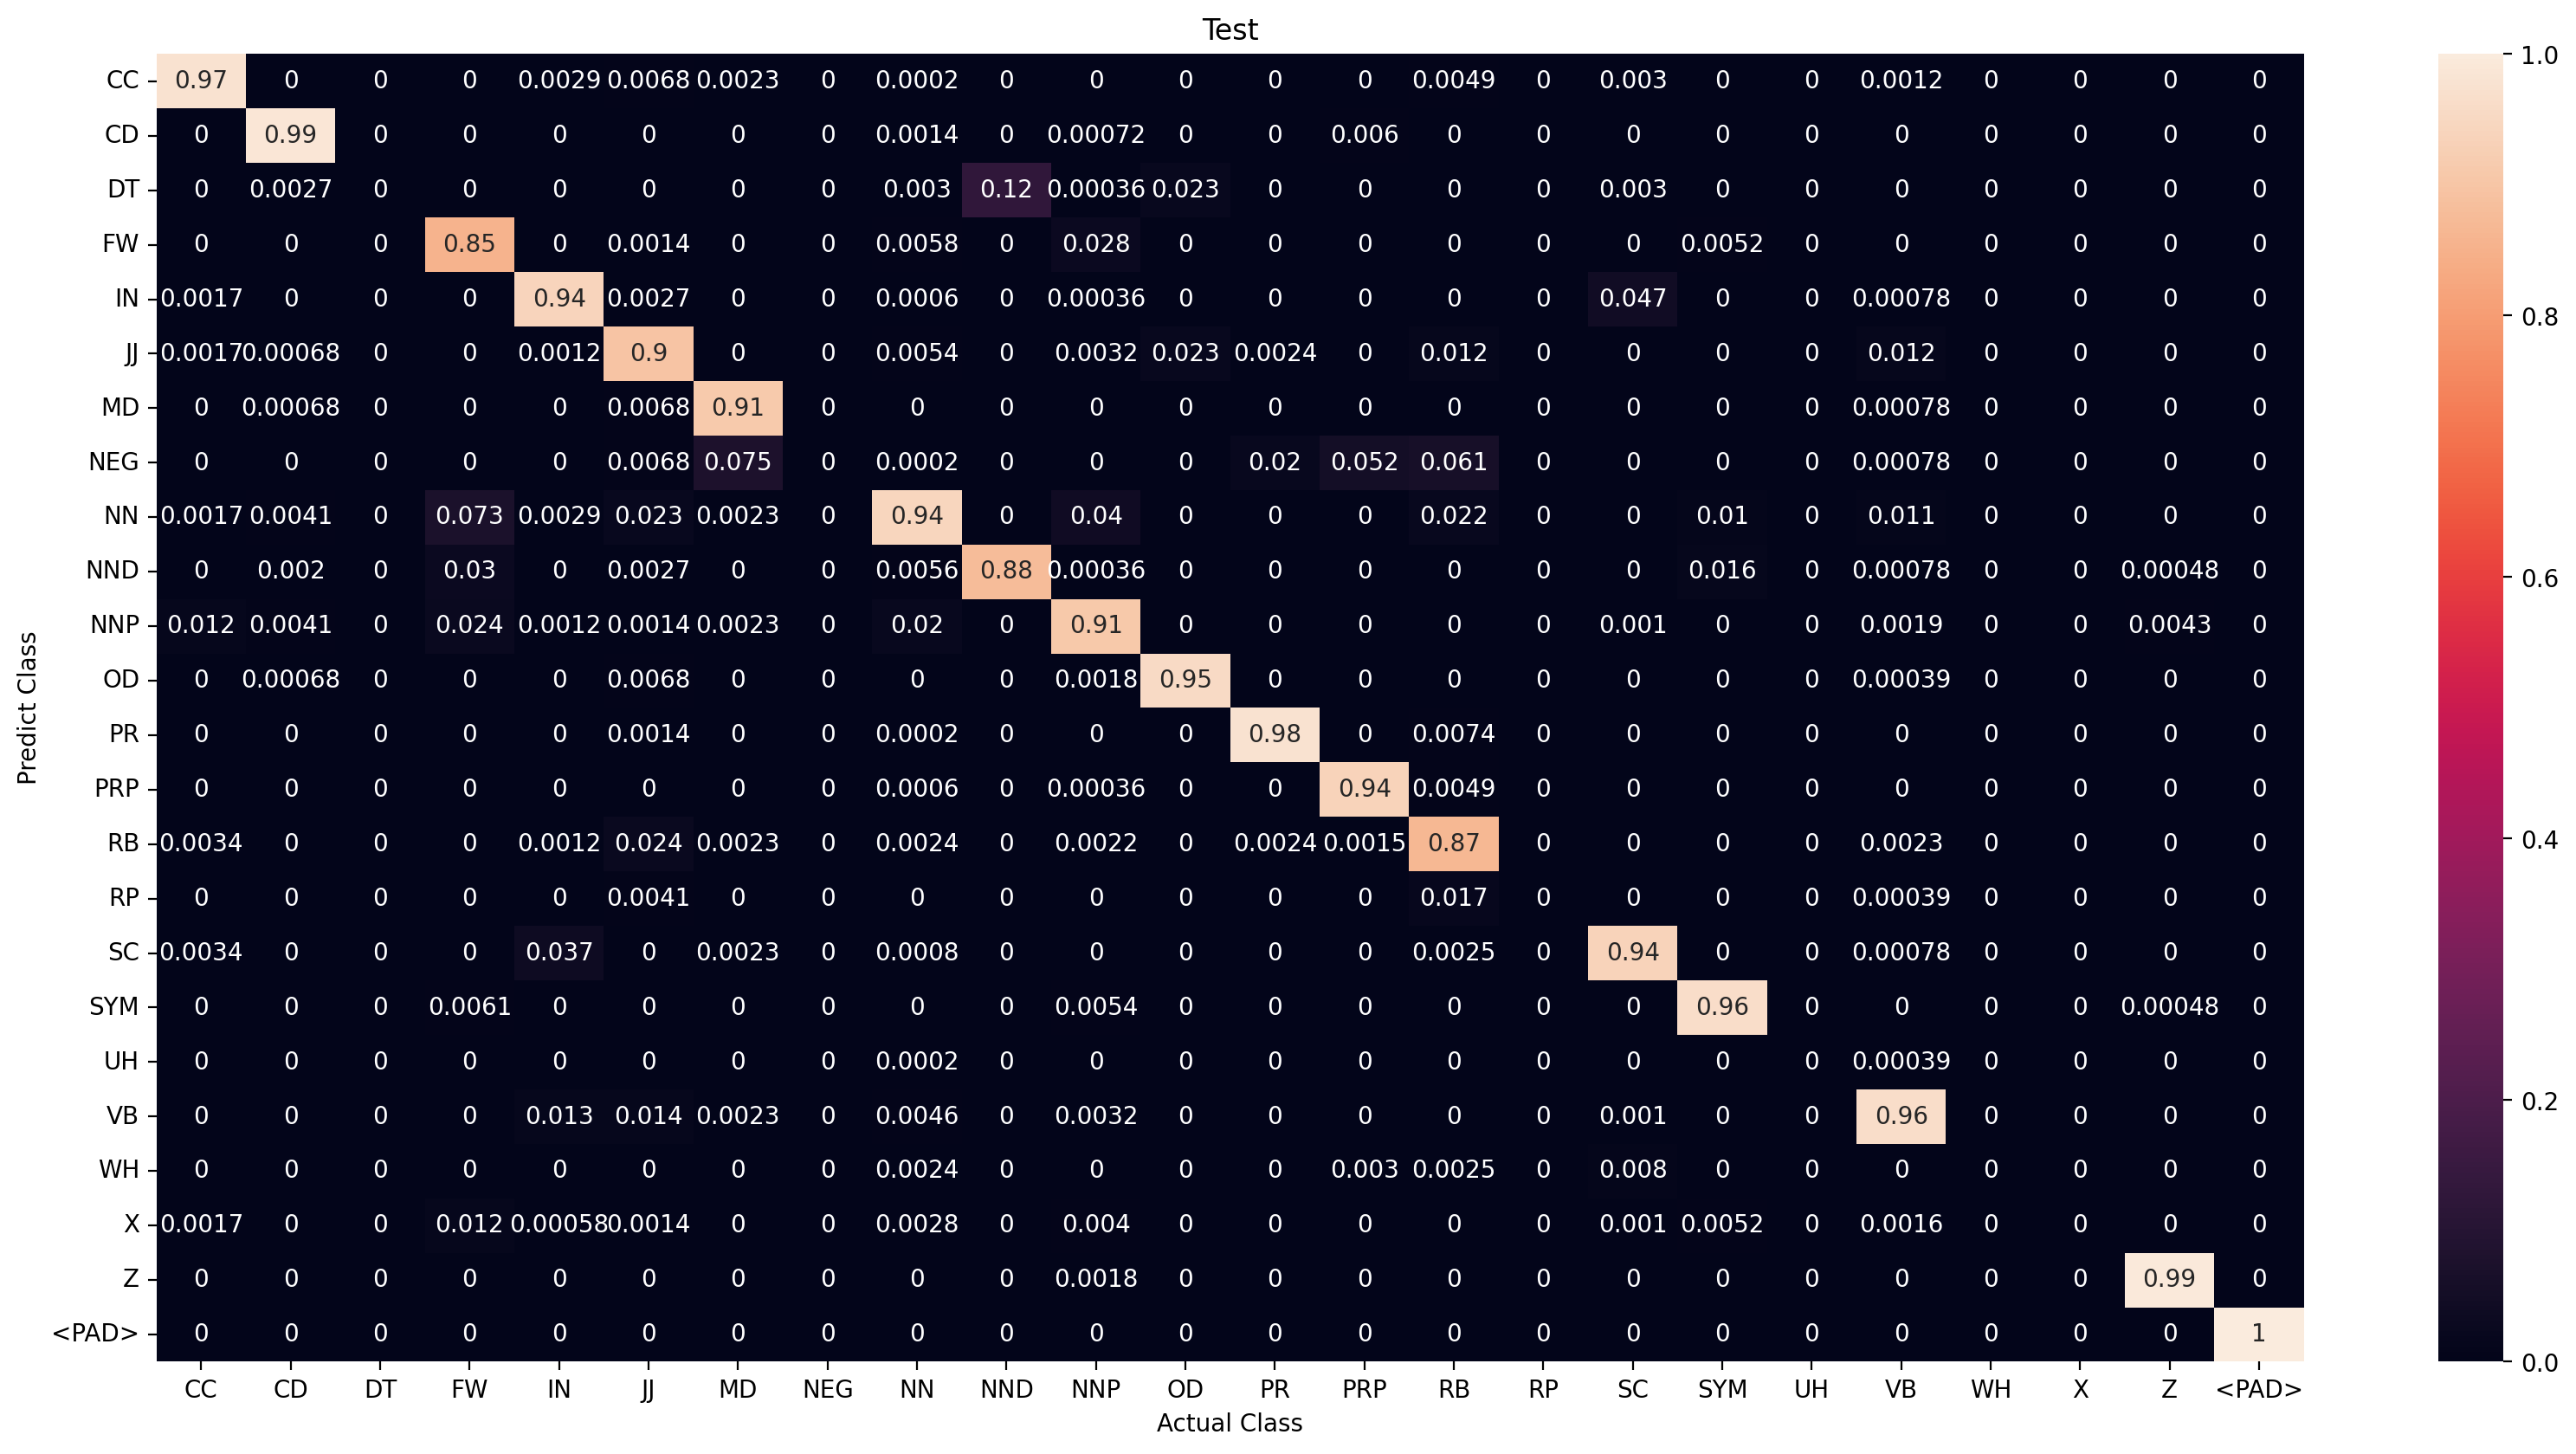

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5270       | CC    : 121      |
| CD    : 12882  | CD    : 12794      | CD    : 88       |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1386       | FW    : 304      |
| IN    : 15403  | IN    : 15292      | IN    : 111      |
| JJ    : 7018   | JJ    : 6682       | JJ    : 336      |
| MD    : 3810   | MD    : 3684       | MD    : 126      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44216      | NN    : 512      |
| NND   : 1019   | NND   : 531        | NND   : 488      |
| NNP   : 24885  | NNP   : 24419      | NNP   : 466      |
| OD    : 534    | OD    : 529        | OD    : 5        |
| PR    : 3842   | PR    : 3785       | PR    : 57       |
| PRP   : 5405   | PRP   : 5367       | PRP   : 38       |
| RB    : 3553   | RB    : 3318       | RB    : 235      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11159
Wrong prediction            : 649
Percentage correct oov pred : 94.50372628726286

Validation
Number OOV token            : 3395
Correct prediction          : 3018
Wrong prediction            : 377
Percentage correct oov pred : 88.89543446244477

Test
Number OOV token            : 1359
Correct prediction          : 1205
Wrong prediction            : 154
Percentage correct oov pred : 88.66813833701251



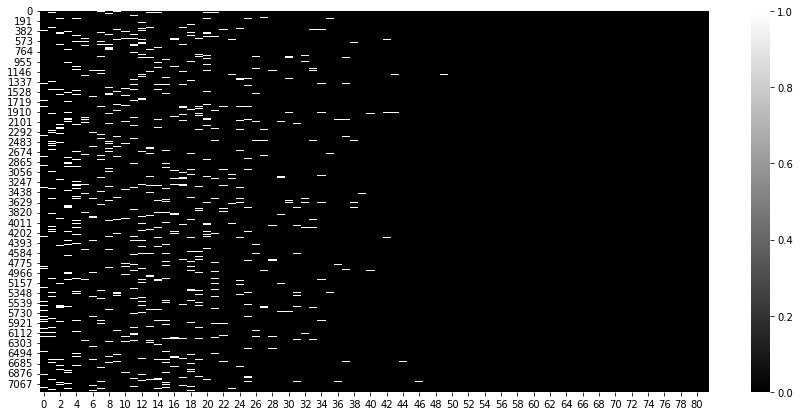

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

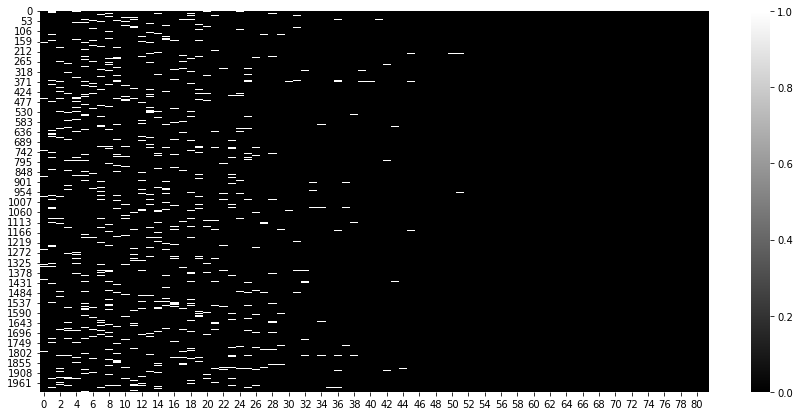

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

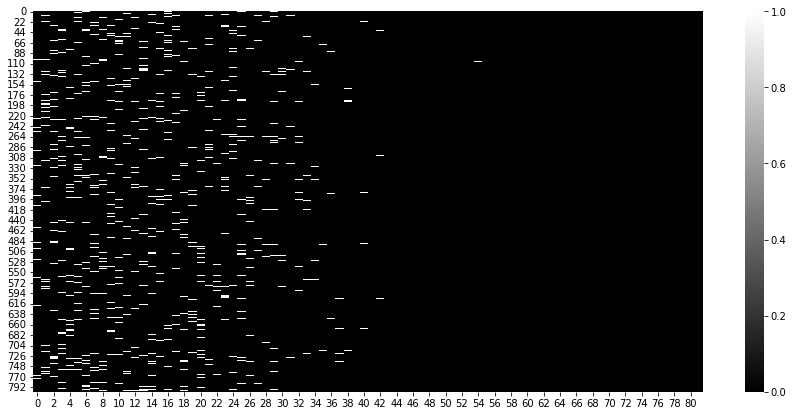

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);